Importing

In [42]:
import torch
from torch.optim import Adam
from torch.optim import LBFGS
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import copy
import seaborn as sns
sns.set_style('darkgrid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Physical System to Model: 2D Deformation, Linear Isotropic

In [43]:
#DBC, positions and displacments
pos = [(0.0,0.0)]
disp = [(0.0,0.0)]
pos, disp = torch.tensor(pos).requires_grad_(True).to(device),torch.tensor(disp).requires_grad_(True).to(device)
DBC = [pos,disp]

#NBC, Scalar Traction Force, Normal Vector, and Position.
T_hat = [(-2.0,0)]
n_hat = [(1.0,0)]
T_pos = [(10.0,5.0)]
T_hat, n_hat, T_pos = torch.tensor(T_hat).requires_grad_(True).t().to(device),torch.tensor(n_hat).requires_grad_(True).t().to(device),torch.tensor(T_pos).requires_grad_(True).to(device)
NBC = [T_hat,n_hat,T_pos]


# Physical Parameters, E = Youngs Modulus, v = Poisson's ratio.
# Rubber
p = dict(E=4.0, v=0.45)
#Stiffness mat, 2D
C = [[1, -p['v'], 0],
     [-p['v'], 1, 0],
     [0, 0, 1+p['v']]]
C = torch.tensor(C).to(device)
C = C/p['E']
C = C.requires_grad_(True)

Creating vector for Training Range

In [44]:
m = 10
# Range of t to be modelled [0,10]
combi = torch.linspace(0,m,20)
train = torch.combinations(combi, with_replacement=True).requires_grad_(True)
train = train.to(device)

Numerical Solution?

In [45]:
#Sol?

Plotting

In [46]:
def plot_comp():
    x_plot = np.linspace(0, m, 5)
    y_plot = np.linspace(0, m, 5)

    combi = torch.linspace(0,m,5).to(device)
    plot_input = torch.combinations(combi, with_replacement=True).requires_grad_(True)
    pred = model(plot_input)
    
    _, loss_absolute = loss_fn(model, plot_input)
    pred_plot = pred.cpu().detach().numpy() + plot_input.cpu().detach().numpy()

    plt.scatter(pred_plot[:,0].T,pred_plot[:,1].T,label='Deformed',marker='.')
    plt.xlabel('Position')
    plt.title(f"Deformation, Loss: {loss_absolute:.2E}, Epoch {epoch}")
    plt.show()
    plt.clf()

Creating the Model

In [47]:
# i_num nodes, i_len nodes per layer and Tanh activation fn, wide and shallow (64x4)
i_num = 2
i_len = 64
#params to take and approximate
params_in = 2
params_out = 2

# fn to create model
def pinn(input_size, output_size, num_layers, nodes_per_layer, activation):
    layers = []
    
    # Input layer
    layers.append(nn.Linear(input_size, nodes_per_layer))
    
    # Hidden layers
    for layer in range(num_layers):
        layers.append(nn.Linear(nodes_per_layer, nodes_per_layer))
        if layer == 0 and activation==Siren:
            layers.append(activation(l=0))
        else:
            layers.append(activation())
    
    # Output layer
    layers.append(nn.Linear(nodes_per_layer, output_size))
    
    return nn.Sequential(*layers)

# custom trainable Tanh activation fn
class TTanh(nn.Module):
    def __init__(self, features=i_len):
        super().__init__()
        self.features = features
        self.a = nn.Parameter(torch.randn(1, features))
        
    def forward(self, x):
        return torch.tanh(self.a * x)

#custom SIREN activation fn
class Siren(nn.Module):
    def __init__(self, features=i_len, l=1):
        super(Siren, self).__init__()
        self.features = features
        # Learnable parameters for the phase and bias
        if l: w = 1 
        else: w = 30
        n = torch.sqrt(torch.tensor(6.0/features))
        self.a_weight = nn.Parameter((torch.rand(1, features) *2*n - n)*w)
        self.a_bias = nn.Parameter(torch.randn(1, features))

    def forward(self, x):
        # Apply the periodic activation function
        return torch.sin( self.a_weight*x + self.a_bias)

# Model to be trained using only Adam
model = pinn(params_in, params_out, i_num, i_len, TTanh)
model.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=64, bias=True)
  (2): TTanh()
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): TTanh()
  (5): Linear(in_features=64, out_features=2, bias=True)
)

Loss Function has the following components:

Physics Loss:

$\mathcal{L}_{Phy} = \frac{1}{N}\sum[\frac{\partial \sigma_{ij}}{\partial x_{j}}]^2$

NBC Loss:

$\mathcal{L}_{NBC} = \frac{1}{N}\sum[\sigma.n - \hat{T}]^2$

DBC Loss:

$\mathcal{L}_{DBC} = \frac{1}{N}\sum[u-\hat{u}]^2$

In [48]:
def Stress(model,input):
    # Strain from displacement field
    pred = model(input)
    
    dux = torch.autograd.grad(pred[:,0], input, torch.ones_like(pred[:,0]), retain_graph=True, create_graph=True)[0]
    duy = torch.autograd.grad(pred[:,1], input, torch.ones_like(pred[:,1]), retain_graph=True, create_graph=True)[0]
    
    duxdx = dux[:,0]
    duxdy = dux[:,1]
    duydx = duy[:,0]
    duydy = duy[:,1]

    epsilon = torch.stack((duxdx, duydy, 0.5 * (duydx + duxdy)))
    
    # Stress from Strain and Constitutive matrix
    sigma_3xn = C @ epsilon
    
    return sigma_3xn[0,:],sigma_3xn[1,:],sigma_3xn[2,:]

In [49]:
def loss_fn(model, batch):
    # model: model
    # batch: vector with x

    # Calulate loss from initial conditions (DBC)
    DBC_loss = ((model(DBC[0])-DBC[1])**2).mean()

    #Calculating NBC Loss
    sxx_NBC,syy_NBC,sxy_NBC = Stress(model,NBC[2])
    syx_NBC = sxy_NBC.clone()

    sigma_1x2_x_NBC = torch.stack((sxx_NBC,syx_NBC), dim=1)
    sigma_1x2_y_NBC = torch.stack((sxy_NBC,syy_NBC), dim=1)
    sigma_2x2_NBC = torch.cat((sigma_1x2_x_NBC, sigma_1x2_y_NBC), dim=0)

    #NBC Loss
    NBC_loss = (((sigma_2x2_NBC @ NBC[1]) - NBC[0])**2).mean()


    #Physics Loss
    #Stress
    sxx_phy,syy_phy,sxy_phy = Stress(model,batch)

    #Divergence of Stress
    dsxx = torch.autograd.grad(sxx_phy, batch, torch.ones_like(sxx_phy), retain_graph=True, create_graph=True)[0]
    dsyy = torch.autograd.grad(syy_phy, batch, torch.ones_like(sxx_phy), retain_graph=True, create_graph=True)[0]
    dsxy = torch.autograd.grad(sxy_phy, batch, torch.ones_like(sxx_phy), retain_graph=True, create_graph=True)[0]

    dsxxdx = dsxx[:,0]
    dsyydy = dsyy[:,1]
    dsxydx = dsxy[:,0]
    dsxydy = dsxy[:,1]

    div_stress = torch.stack((dsxxdx + dsxydy, dsyydy + dsxydx), dim=0)
    phy_loss = ((div_stress)**2).mean()



    # calculate weighted loss
    DBC_loss_weighted,NBC_loss_weighted = DBC_loss*DBC_weight , NBC_loss*NBC_weight

    obtain_grads([DBC_loss_weighted, NBC_loss_weighted, phy_loss])

    loss_weighted = DBC_loss_weighted + NBC_loss_weighted + phy_loss
    loss_absolute = DBC_loss + NBC_loss + phy_loss

    return loss_weighted, loss_absolute

Loss weights are dynamically updated using:

$\hat{\lambda}^{(n)}_{ic} = \frac{max \{| {\nabla_{\theta}} \mathcal{L}_{physics} |\} } {| \overline{ {\nabla_{\theta}} \mathcal{L}_{ic} } |} $
or
$ \frac{std \{ {\nabla_{\theta}} \mathcal{L}_{physics} \} } {std \{ {\nabla_{\theta}} \mathcal{L}_{ic} \} } $
or
$\frac{|| {\nabla_{\theta}} \mathcal{L}_{physics} ||_{2} } {|| {\nabla_{\theta}} \mathcal{L}_{ic} ||_{2} } $

$\lambda^{(n)}_{ic} = \alpha \lambda^{(n-1)}_{ic} + (1 - \alpha) \hat{\lambda}^{(n)}_{ic}  $

In [50]:
phy_grads, NBC_grads, DBC_grads = list(), list(), list()
list_of_lists = [DBC_grads, NBC_grads, phy_grads]
NBC_weight, DBC_weight = 1.0, 1.0

def weight_update_max_mean(w_update, a=0.9):
    phy_loss_max = torch.max(torch.abs(torch.stack(phy_grads[-w_update:])))
    
    NBC_loss_mean = torch.mean(torch.abs(torch.stack(NBC_grads[-w_update:])))
    NBC_weight_hat = (phy_loss_max / NBC_loss_mean).item()
    new_NBC_weight = (1-a)*NBC_weight + a*NBC_weight_hat

    DBC_loss_mean = torch.mean(torch.abs(torch.stack(DBC_grads[-w_update:])))
    DBC_weight_hat = (phy_loss_max / DBC_loss_mean).item()
    new_DBC_weight = (1-a)*DBC_weight + a*DBC_weight_hat

    return new_NBC_weight, new_DBC_weight

def weight_update_std(w_update, a=0.9):
    phy_loss_std = torch.std(torch.stack(phy_grads[-w_update:]))

    NBC_loss_std = torch.std(torch.stack(NBC_grads[-w_update:]))
    NBC_weight_hat = (phy_loss_std / NBC_loss_std).item()
    new_NBC_weight = (1-a)*NBC_weight + a*NBC_weight_hat

    DBC_loss_std = torch.std(torch.stack(DBC_grads[-w_update:]))
    DBC_weight_hat = (phy_loss_std / DBC_loss_std).item()
    new_DBC_weight = (1-a)*DBC_weight + a*DBC_weight_hat

    return new_NBC_weight, new_DBC_weight

def weight_update_norm(w_update, a=0.9):
    phy_loss_norm = torch.linalg.matrix_norm(torch.stack(phy_grads[-w_update:]))
    
    NBC_loss_norm = torch.linalg.matrix_norm(torch.stack(NBC_grads[-w_update:]))
    NBC_weight_hat = (phy_loss_norm / NBC_loss_norm).item()
    new_NBC_weight = (1-a)*NBC_weight + a*NBC_weight_hat

    DBC_loss_norm = torch.linalg.matrix_norm(torch.stack(DBC_grads[-w_update:]))
    DBC_weight_hat = (phy_loss_norm / DBC_loss_norm).item()
    new_DBC_weight = (1-a)*DBC_weight + a*DBC_weight_hat

    return new_NBC_weight, new_DBC_weight

def obtain_grads(losses):

    for i in range(len(list_of_lists)):
        optim.zero_grad()
        losses[i].backward(retain_graph=True)
        temp = list()
        for name, param in model.named_parameters():
            if param.grad is not None:
                temp.append(torch.reshape(param.grad,(-1,)))
        list_of_lists[i].append(torch.cat(temp))
        
    return

Checkpoint During Training

In [51]:
best_model_adam = {'epoch':-1}
best_model_LBFGS = {'epoch':-1}

def checkpoint(best_model):
    if (best_model['epoch'] == -1) or (prev_loss[-1] < best_model['loss']):
        best_model = {
            'epoch': epoch,
            'model_state_dict': copy.deepcopy(copy.deepcopy(model.state_dict())),
            'optimizer_state_dict': copy.deepcopy(copy.deepcopy(optim.state_dict())),
            'loss': prev_loss[-1],
                    }
    return best_model

Plot Training Data

In [52]:
def plot_train(n=0):
    plt.plot(np.log10(prev_loss[n:]),c='tab:blue',label='Log Loss')
    plt.title(f"Log Loss over {len(prev_loss[n:])} Calls")
    plt.xlabel("Calls")
    plt.ylabel("Log Loss")
    plt.show()
    plt.clf()

    plt.plot(torch.log10(torch.mean(torch.abs(torch.stack(phy_grads[n:],1)),0)).cpu(),label='log mean phy loss grad',c='tab:green')
    plt.title(f"Gradient of parameters wrt Physics Loss over {len(prev_loss[n:])} Calls")
    plt.xlabel("Loss Computations")
    plt.ylabel("Log Mean gradients for model parameters")
    plt.legend()
    plt.show()
    plt.clf()

    plt.plot(torch.log10(torch.mean(torch.abs(torch.stack(NBC_grads[n:],1)),0)).cpu(),label='log mean NBC loss grad',c='tab:orange')
    plt.title(f"Gradient of parameters wrt NBC Loss over {len(prev_loss[n:])} Calls")
    plt.xlabel("Loss Computations")
    plt.ylabel("Log Mean gradients for model parameters")
    plt.legend()
    plt.show()
    plt.clf()

    plt.plot(torch.log10(torch.mean(torch.abs(torch.stack(DBC_grads[n:],1)),0)).cpu(),label='log mean DBC loss grad',c='tab:red')
    plt.title(f"Gradient of parameters wrt DBC Loss over {len(prev_loss[n:])} Calls")
    plt.xlabel("Loss Computations")
    plt.ylabel("Log Mean gradients for model parameters")
    plt.legend()
    plt.show()
    plt.clf()

Closure Fn for Optimisers

In [53]:
def closure():
    loss_weighted, loss_absolute = loss_fn(model, train)
    optim.zero_grad()
    loss_weighted.backward()
    prev_loss.append(loss_absolute.item())
    return loss_weighted

Training with Adam

Finished epoch 0, latest loss 2.01E+00


Finished epoch 1000, latest loss 2.24E-05
Finished epoch 2000, latest loss 8.25E-06


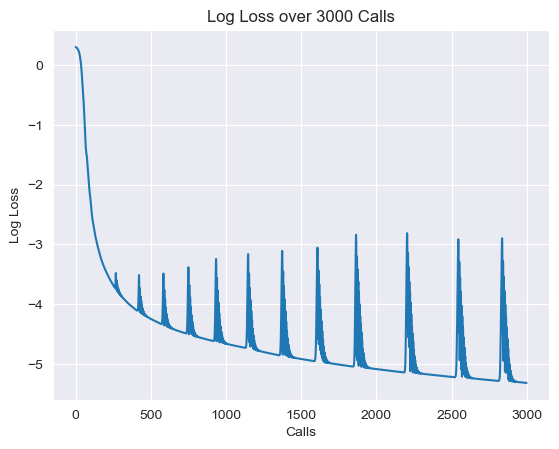

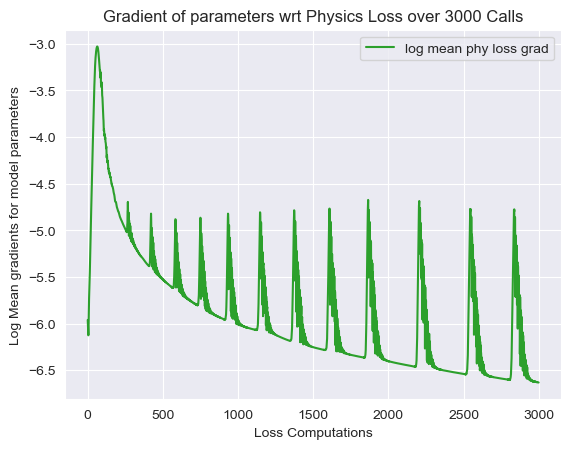

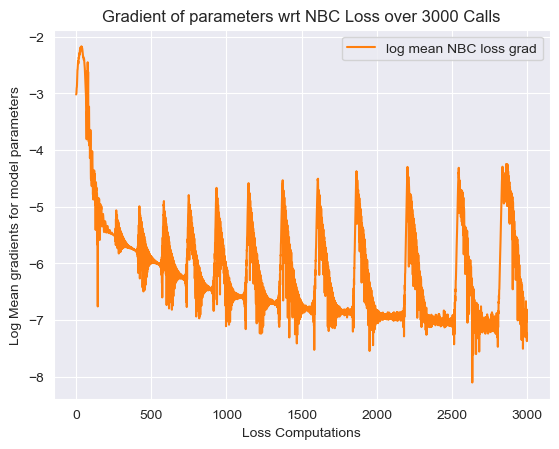

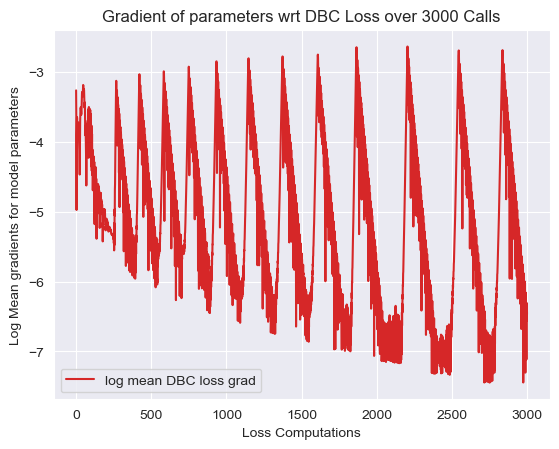

<Figure size 640x480 with 0 Axes>

In [54]:
# train
n_epochs = (3000,20)
w_update = 1
# start with Adam optimizer
optim = Adam(model.parameters())
prev_loss = list()

for epoch in range(n_epochs[0]):
    
    optim.step(closure)
    best_model_adam = checkpoint(best_model_adam)

    #if not (epoch%w_update): NBC_weight , DBC_weight = weight_update_norm(w_update)
    if not (epoch%1000): print(f'Finished epoch {epoch}, latest loss {prev_loss[-1]:.2E}')

# plot for Adam optimization stage
plot_train()

Training with L-BGFS

Finished epoch 3000, latest loss 4.84E-06
Finished epoch 3010, latest loss 4.84E-06


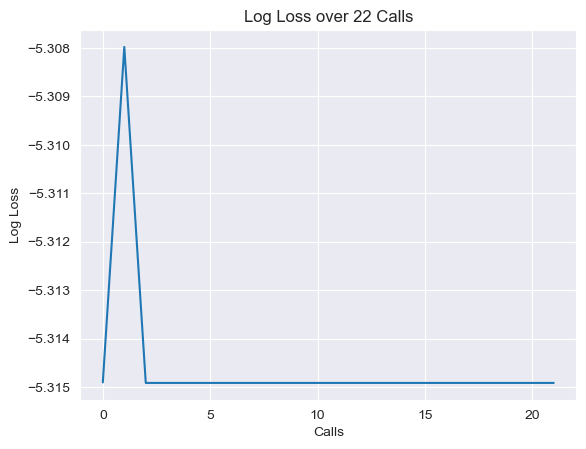

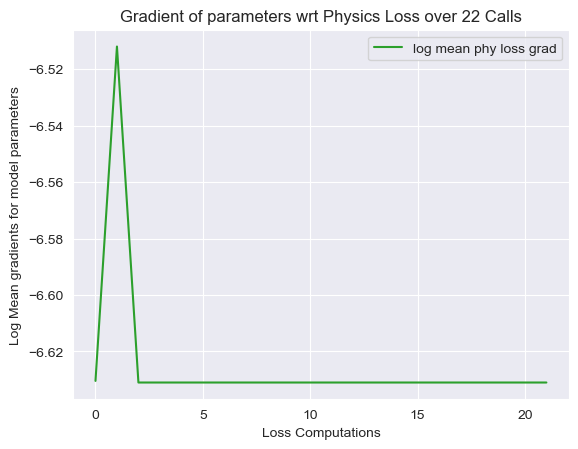

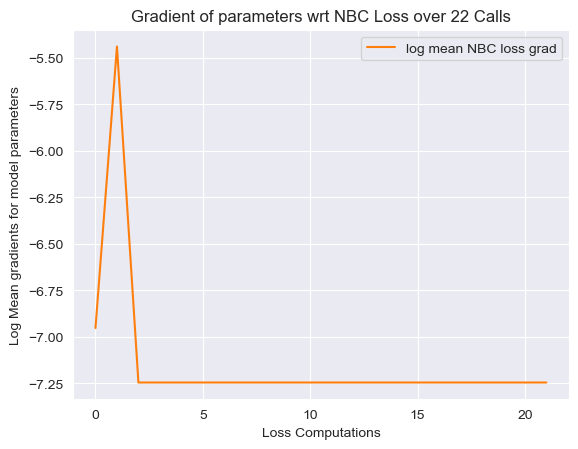

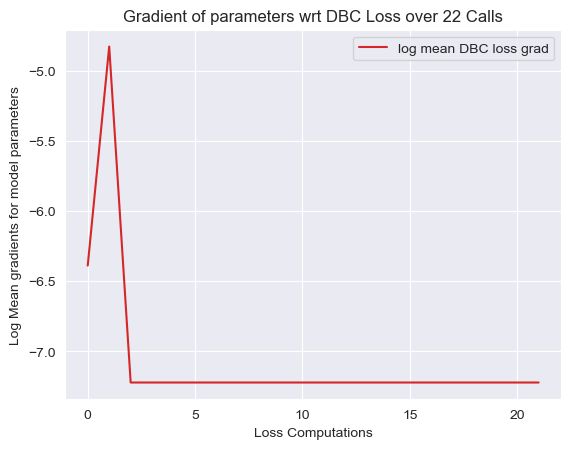

<Figure size 640x480 with 0 Axes>

In [55]:
# Change optim to L-BFGS
optim = LBFGS(model.parameters())

for epoch in range(n_epochs[0],sum(n_epochs)):
    
    optim.step(closure)
    best_model_LBFGS = checkpoint(best_model_LBFGS)

    #if not (epoch%w_update): ic_weight = weight_update_norm(w_update)
    if not (epoch%10): print(f'Finished epoch {epoch}, latest loss {prev_loss[-1]:.2E}')

plot_train(n_epochs[0])

Plot Best L-BFGS Model

pred
[[ 1.3879035e-06 -2.2780150e-06]
 [ 2.6527388e+00  3.8417079e+00]
 [ 3.0075567e+00  4.4013872e+00]
 [ 3.1386378e+00  4.5748720e+00]
 [ 3.2069368e+00  4.6476064e+00]
 [ 2.6995356e+00  4.6033430e+00]
 [ 2.9220479e+00  4.6705227e+00]
 [ 3.0641246e+00  4.7479563e+00]
 [ 3.1504638e+00  4.7885861e+00]
 [ 2.9836795e+00  5.0718622e+00]
 [ 3.0529573e+00  4.9974546e+00]
 [ 3.1235998e+00  4.9728827e+00]
 [ 3.0581791e+00  5.2031312e+00]
 [ 3.1126716e+00  5.1361971e+00]
 [ 3.0918219e+00  5.2613153e+00]]
plotting
[[ 0.   0. ]
 [ 0.   2.5]
 [ 0.   5. ]
 [ 0.   7.5]
 [ 0.  10. ]
 [ 2.5  2.5]
 [ 2.5  5. ]
 [ 2.5  7.5]
 [ 2.5 10. ]
 [ 5.   5. ]
 [ 5.   7.5]
 [ 5.  10. ]
 [ 7.5  7.5]
 [ 7.5 10. ]
 [10.  10. ]]
sum
[[ 1.3879035e-06 -2.2780150e-06]
 [ 2.6527388e+00  6.3417082e+00]
 [ 3.0075567e+00  9.4013872e+00]
 [ 3.1386378e+00  1.2074872e+01]
 [ 3.2069368e+00  1.4647606e+01]
 [ 5.1995354e+00  7.1033430e+00]
 [ 5.4220476e+00  9.6705227e+00]
 [ 5.5641246e+00  1.2247956e+01]
 [ 5.6504641e+00  1.478858

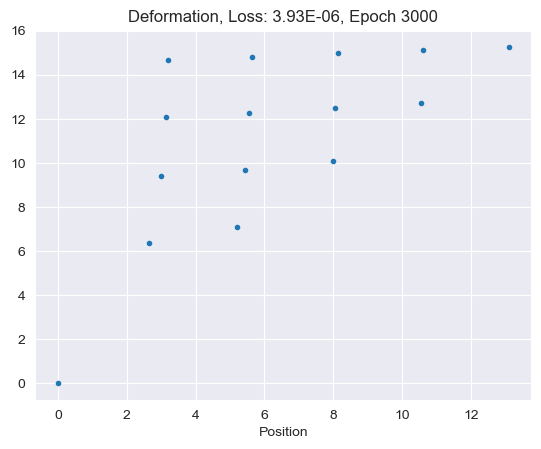

<Figure size 640x480 with 0 Axes>

In [56]:
model.load_state_dict(best_model_LBFGS['model_state_dict'])
optim.load_state_dict(best_model_LBFGS['optimizer_state_dict'])
epoch = best_model_LBFGS['epoch']
loss = best_model_LBFGS['loss']
model.eval()

plot_comp()

Plot Best Adam Model

pred
[[7.3958654e-06 7.4170530e-06]
 [2.6527417e+00 3.8417110e+00]
 [3.0075595e+00 4.4013896e+00]
 [3.1386406e+00 4.5748749e+00]
 [3.2069395e+00 4.6476092e+00]
 [2.6995385e+00 4.6033463e+00]
 [2.9220507e+00 4.6705251e+00]
 [3.0641270e+00 4.7479591e+00]
 [3.1504662e+00 4.7885890e+00]
 [2.9836824e+00 5.0718651e+00]
 [3.0529597e+00 4.9974570e+00]
 [3.1236022e+00 4.9728856e+00]
 [3.0581815e+00 5.2031341e+00]
 [3.1126740e+00 5.1361995e+00]
 [3.0918243e+00 5.2613177e+00]]
plotting
[[ 0.   0. ]
 [ 0.   2.5]
 [ 0.   5. ]
 [ 0.   7.5]
 [ 0.  10. ]
 [ 2.5  2.5]
 [ 2.5  5. ]
 [ 2.5  7.5]
 [ 2.5 10. ]
 [ 5.   5. ]
 [ 5.   7.5]
 [ 5.  10. ]
 [ 7.5  7.5]
 [ 7.5 10. ]
 [10.  10. ]]
sum
[[7.39586540e-06 7.41705298e-06]
 [2.65274167e+00 6.34171104e+00]
 [3.00755954e+00 9.40139008e+00]
 [3.13864064e+00 1.20748749e+01]
 [3.20693946e+00 1.46476097e+01]
 [5.19953823e+00 7.10334635e+00]
 [5.42205048e+00 9.67052460e+00]
 [5.56412697e+00 1.22479591e+01]
 [5.65046597e+00 1.47885895e+01]
 [7.98368263e+00 1.0071

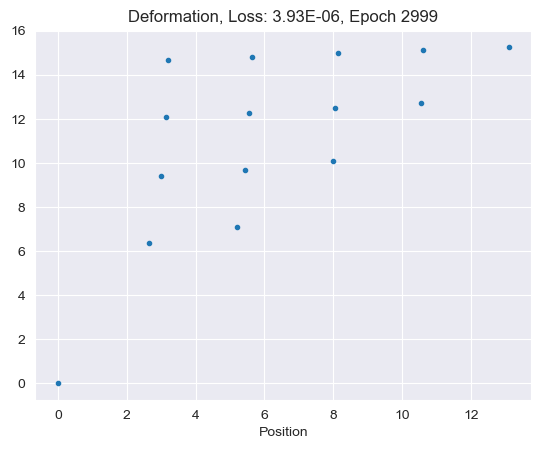

<Figure size 640x480 with 0 Axes>

In [57]:
model.load_state_dict(best_model_adam['model_state_dict'])
optim.load_state_dict(best_model_adam['optimizer_state_dict'])
epoch = best_model_adam['epoch']
loss = best_model_adam['loss']
model.eval()

plot_comp()

Retraining wih best model using Adam

Finished epoch 3000, latest loss 4.84E-06
Finished epoch 3010, latest loss 4.84E-06


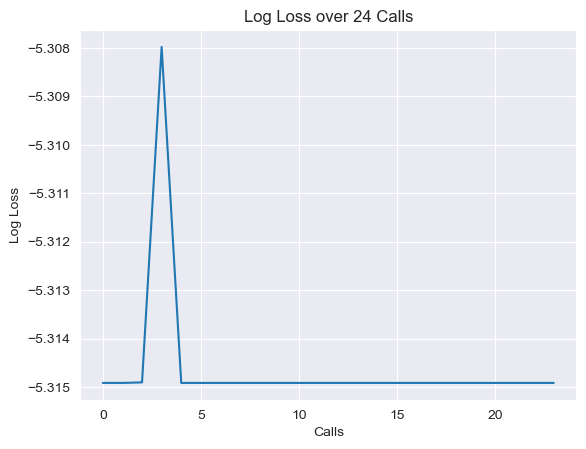

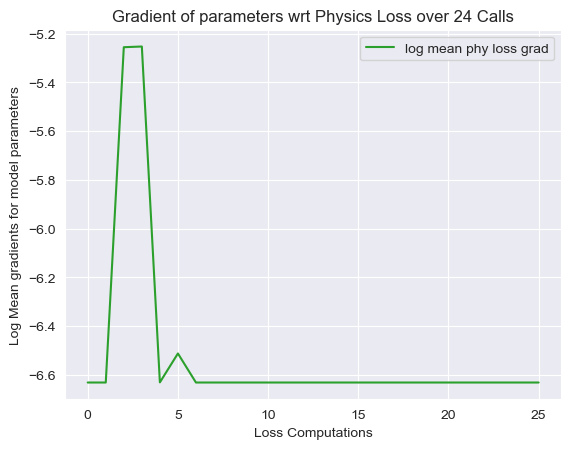

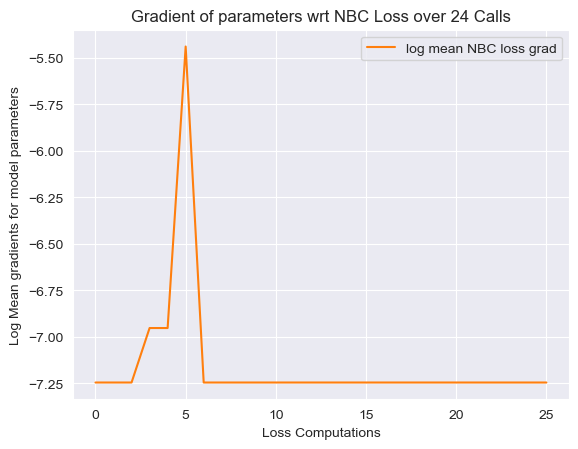

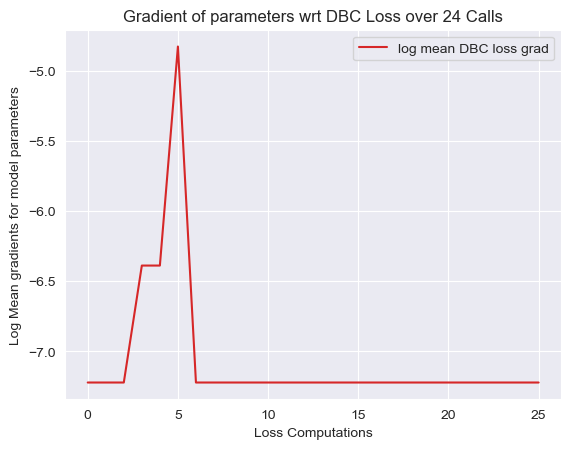

<Figure size 640x480 with 0 Axes>

In [58]:
optim = LBFGS(model.parameters())

for epoch in range(n_epochs[0],sum(n_epochs)):
    
    optim.step(closure)
    best_model_LBFGS = checkpoint(best_model_LBFGS)

    if not (epoch%w_update): ic_weight = weight_update_norm(w_update)
    if not (epoch%10): print(f'Finished epoch {epoch}, latest loss {prev_loss[-1]:.2E}')

plot_train(sum(n_epochs))

Plotting best model

pred
[[ 1.3879035e-06 -2.2780150e-06]
 [ 2.6527388e+00  3.8417079e+00]
 [ 3.0075567e+00  4.4013872e+00]
 [ 3.1386378e+00  4.5748720e+00]
 [ 3.2069368e+00  4.6476064e+00]
 [ 2.6995356e+00  4.6033430e+00]
 [ 2.9220479e+00  4.6705227e+00]
 [ 3.0641246e+00  4.7479563e+00]
 [ 3.1504638e+00  4.7885861e+00]
 [ 2.9836795e+00  5.0718622e+00]
 [ 3.0529573e+00  4.9974546e+00]
 [ 3.1235998e+00  4.9728827e+00]
 [ 3.0581791e+00  5.2031312e+00]
 [ 3.1126716e+00  5.1361971e+00]
 [ 3.0918219e+00  5.2613153e+00]]
plotting
[[ 0.   0. ]
 [ 0.   2.5]
 [ 0.   5. ]
 [ 0.   7.5]
 [ 0.  10. ]
 [ 2.5  2.5]
 [ 2.5  5. ]
 [ 2.5  7.5]
 [ 2.5 10. ]
 [ 5.   5. ]
 [ 5.   7.5]
 [ 5.  10. ]
 [ 7.5  7.5]
 [ 7.5 10. ]
 [10.  10. ]]
sum
[[ 1.3879035e-06 -2.2780150e-06]
 [ 2.6527388e+00  6.3417082e+00]
 [ 3.0075567e+00  9.4013872e+00]
 [ 3.1386378e+00  1.2074872e+01]
 [ 3.2069368e+00  1.4647606e+01]
 [ 5.1995354e+00  7.1033430e+00]
 [ 5.4220476e+00  9.6705227e+00]
 [ 5.5641246e+00  1.2247956e+01]
 [ 5.6504641e+00  1.478858

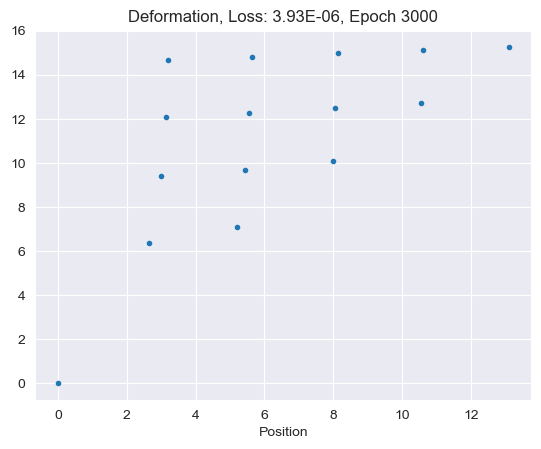

<Figure size 640x480 with 0 Axes>

In [59]:
model.load_state_dict(best_model_LBFGS['model_state_dict'])
optim.load_state_dict(best_model_LBFGS['optimizer_state_dict'])
epoch = best_model_LBFGS['epoch']
loss = best_model_LBFGS['loss']
model.eval()

plot_comp()

Saving Best Model

In [60]:
#model.load_state_dict(best_model['model_state_dict'])
#optim.load_state_dict(best_model['optimizer_state_dict'])
#epoch = best_model['epoch']
#loss = best_model['loss']

#PATH = f"Models\\{loss:.2E}_{epoch}.tar"
#torch.save(best_model, PATH)

Load Model

In [61]:
#PATH = "Models\\"

#checkpoint = torch.load(PATH, map_location=device)
#model.load_state_dict(checkpoint['model_state_dict'])
#optim.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#loss = checkpoint['loss']

#model.eval()
# - or -
#model.train()

#plot_comp()